# VAV Reheat System Tutorial: From Basics to Advanced Control

Welcome to this comprehensive tutorial on Variable Air Volume (VAV) systems with reheat! This notebook will guide you through understanding, implementing, and optimizing HVAC control systems using Python CDL.

## What You'll Learn

1. **VAV System Fundamentals** - How VAV systems work and why they're energy efficient
2. **ASHRAE Guideline 36 Sequences** - Industry-standard control logic
3. **Zone-Level Control** - Temperature control with dampers and reheat
4. **AHU Control** - Central air handling with economizer and fan optimization
5. **System Integration** - Coordinating multiple zones for whole-building control
6. **Performance Analysis** - Visualizing and optimizing system behavior

## Prerequisites

- Basic Python knowledge
- Understanding of temperature and airflow concepts
- Familiarity with control systems (PID control) is helpful but not required

Let's get started!

---

## Section 1: Introduction to VAV Systems

### What is a VAV System?

A **Variable Air Volume (VAV)** system adjusts the amount of conditioned air delivered to each zone based on demand. Unlike constant volume systems that vary temperature, VAV systems vary airflow.

### Key Components:

```
┌─────────────────────────────────────────────────────────┐
│                    Air Handling Unit (AHU)               │
│  ┌──────┐  ┌────────┐  ┌──────┐  ┌──────┐  ┌────────┐ │
│  │ OA   │  │ Mixed  │  │Cooling│  │Heating│  │ Supply │ │
│  │Damper│→ │  Air   │→ │ Coil  │→ │ Coil  │→ │  Fan   │ │
│  └──────┘  └────────┘  └──────┘  └──────┘  └────────┘ │
└────────────────────────────────────┬────────────────────┘
                                     │ Supply Duct
                    ┌────────────────┼────────────────┐
                    │                │                │
              ┌─────▼─────┐    ┌────▼────┐    ┌─────▼─────┐
              │ VAV Box 1 │    │VAV Box 2│    │ VAV Box 3 │
              │  +Reheat  │    │ +Reheat │    │  +Reheat  │
              └─────┬─────┘    └────┬────┘    └─────┬─────┘
                    │               │               │
                  Zone 1          Zone 2          Zone 3
```

### Why VAV with Reheat?

**Energy Benefits:**
- Reduced fan energy (30-50% savings vs. constant volume)
- Lower cooling costs from reduced airflow
- Economizer free cooling when outdoor conditions permit

**Comfort Benefits:**
- Individual zone control
- Better humidity control
- Quieter operation at part load

**Reheat Capability:**
- Handles zones with heating needs while others cool
- Maintains ventilation during heating mode
- Common in perimeter zones with high heat loss

### Setup: Import Required Libraries

First, let's import all the libraries we'll need for this tutorial.

In [1]:
# Standard library imports
import json
import sys
from pathlib import Path

# Data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Configure matplotlib for notebook
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Add project root to path for imports
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import VAV reheat components from the examples package
from examples.vav_reheat import (
    VAVBoxController,
    ZoneConfig,
    ZoneState,
    ZoneType,
    get_zone_config,
    create_custom_zone_config,
    ModeSelector,
    SupplyFanController,
    ReturnFanController,
    EconomizerController,
    DuctPressureReset
)

print("✓ All imports successful!")
print(f"✓ Python CDL library loaded from: {project_root / 'src'}")

✓ All imports successful!
✓ Python CDL library loaded from: /Users/acedrew/aceiot-projects/python-cdl/src


---

## Section 2: Zone Controllers - The Building Blocks

Let's start with a single VAV zone controller. This is the heart of zone-level temperature control.

### ASHRAE Control Sequence Overview

The VAV box controller operates in three modes:

```
Temperature Error vs. Control Response:

Too Cold                  Comfortable                Too Hot
  ├──────────────────────────┼──────────────────────────┤
  │       HEATING MODE       │  DEADBAND  │  COOLING MODE │
  ├──────────────────────────┼────────────┼───────────────┤
  Airflow: MINIMUM          Airflow: MIN   Airflow: MIN→MAX
  Reheat:  MODULATING       Reheat:  OFF   Reheat:  OFF
```

**Mode 1: Cooling Mode** (Room Temp > Cooling Setpoint)
- Increase airflow from minimum to maximum
- Reheat valve fully closed
- PI control on damper position

**Mode 2: Deadband** (Between Heating and Cooling Setpoints)
- Maintain minimum airflow for ventilation
- Reheat valve closed (or slight modulation)
- Energy-saving mode

**Mode 3: Heating Mode** (Room Temp < Heating Setpoint)
- Maintain minimum airflow
- Modulate reheat valve to add heat
- PI control on reheat valve position

### Interactive Example: Single Zone Control

Let's create a VAV controller for a south-facing zone (high solar gain):

In [2]:
# Create a zone configuration for a south perimeter zone
south_config = get_zone_config(ZoneType.SOUTH)

print("South Zone Configuration:")
print(f"  Zone ID: {south_config.zone_id}")
print(f"  Cooling Setpoint: {south_config.cooling_setpoint}°C")
print(f"  Heating Setpoint: {south_config.heating_setpoint}°C")
print(f"  Deadband: {south_config.deadband}°C")
print(f"  Airflow Range: {south_config.min_airflow:.2f} - {south_config.max_airflow:.2f} m³/s")
print(f"  Min Damper Position: {south_config.min_damper_position*100:.0f}%")
print(f"\nPI Tuning:")
print(f"  Damper Control: Kp={south_config.kp_damper}, Ki={south_config.ki_damper}")
print(f"  Reheat Control: Kp={south_config.kp_reheat}, Ki={south_config.ki_reheat}")

South Zone Configuration:
  Zone ID: zone_south
  Cooling Setpoint: 23.0°C
  Heating Setpoint: 21.0°C
  Deadband: 1.0°C
  Airflow Range: 0.20 - 1.00 m³/s
  Min Damper Position: 15%

PI Tuning:
  Damper Control: Kp=0.6, Ki=0.12
  Reheat Control: Kp=0.35, Ki=0.06


### Visualizing Zone Control Response

Let's simulate how the controller responds to temperature changes over time:

In [11]:
def simulate_zone_scenario(scenario_name: str, initial_temp: float, supply_temp: float, 
                          duration_minutes: int = 60):
    """
    Simulate a zone control scenario.
    
    Args:
        scenario_name: Name of the scenario
        initial_temp: Starting room temperature (°C)
        supply_temp: Supply air temperature (°C)
        duration_minutes: Simulation duration in minutes
    """
    # Create controller and state
    controller = VAVBoxController(south_config)
    state = ZoneState(room_temp=initial_temp, supply_air_temp=supply_temp)
    
    # Simulation parameters
    dt = 60.0  # 1 minute time step
    num_steps = duration_minutes
    
    # Data storage
    times = []
    temps = []
    dampers = []
    reheats = []
    airflows = []
    
    # Run simulation
    for step in range(num_steps):
        # Compute control
        state = controller.update_state(state, dt=dt)
        
        # Simple thermal model (demonstration only)
        # Heat gain from supply air
        q_supply = state.airflow * 1.2 * 1005 * (supply_temp - state.room_temp)
        # Heat from reheat coil
        q_reheat = state.reheat_valve_position * 5000  # 5kW max
        # Heat loss/gain through envelope (simplified)
        q_envelope = -2.0 * 100 * (state.room_temp - 15)  # U*A*(Ti-To)
        # Internal gains
        q_internal = 1500  # W (people, equipment, lighting)
        
        # Temperature change
        zone_thermal_mass = 300 * 1.2 * 1005  # volume * density * cp
        dT = ((q_supply + q_reheat + q_envelope + q_internal) * dt) / zone_thermal_mass
        state.room_temp += dT
        
        # Store data
        times.append(step)
        temps.append(state.room_temp)
        dampers.append(state.damper_position * 100)
        reheats.append(state.reheat_valve_position * 100)
        airflows.append(state.airflow * 1000)  # Convert to L/s
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'Zone Control Simulation: {scenario_name}', fontsize=14, fontweight='bold')
    
    # Temperature
    ax = axes[0, 0]
    ax.plot(times, temps, 'b-', linewidth=2, label='Room Temperature')
    ax.axhline(south_config.cooling_setpoint, color='r', linestyle='--', label='Cooling Setpoint')
    ax.axhline(south_config.heating_setpoint, color='orange', linestyle='--', label='Heating Setpoint')
    ax.fill_between(times, south_config.heating_setpoint, south_config.cooling_setpoint, 
                     alpha=0.2, color='green', label='Deadband')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Room Temperature vs. Setpoints')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Damper Position
    ax = axes[0, 1]
    ax.plot(times, dampers, 'g-', linewidth=2)
    ax.fill_between(times, 0, dampers, alpha=0.3, color='green')
    ax.axhline(south_config.min_damper_position * 100, color='gray', linestyle=':', 
               label='Minimum Position')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Damper Position (%)')
    ax.set_title('VAV Damper Control')
    ax.set_ylim([0, 105])
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Reheat Valve
    ax = axes[1, 0]
    ax.plot(times, reheats, 'r-', linewidth=2)
    ax.fill_between(times, 0, reheats, alpha=0.3, color='red')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Reheat Valve Position (%)')
    ax.set_title('Reheat Valve Control')
    ax.set_ylim([0, 105])
    ax.grid(True, alpha=0.3)
    
    # Airflow
    ax = axes[1, 1]
    ax.plot(times, airflows, 'purple', linewidth=2)
    ax.fill_between(times, 0, airflows, alpha=0.3, color='purple')
    ax.axhline(south_config.min_airflow * 1000, color='gray', linestyle=':', 
               label='Minimum Airflow')
    ax.axhline(south_config.max_airflow * 1000, color='gray', linestyle=':', 
               label='Maximum Airflow')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Airflow (L/s)')
    ax.set_title('Zone Airflow Rate')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nScenario Summary: {scenario_name}")
    print(f"  Initial Temperature: {initial_temp:.1f}°C")
    print(f"  Final Temperature: {temps[-1]:.1f}°C")
    print(f"  Temperature Change: {temps[-1] - initial_temp:+.1f}°C")
    print(f"  Average Damper Position: {np.mean(dampers):.1f}%")
    print(f"  Average Reheat Usage: {np.mean(reheats):.1f}%")
    print(f"  Average Airflow: {np.mean(airflows):.1f} L/s")

### Try It Yourself: Different Control Scenarios

Run these cells to see how the controller responds to different conditions:

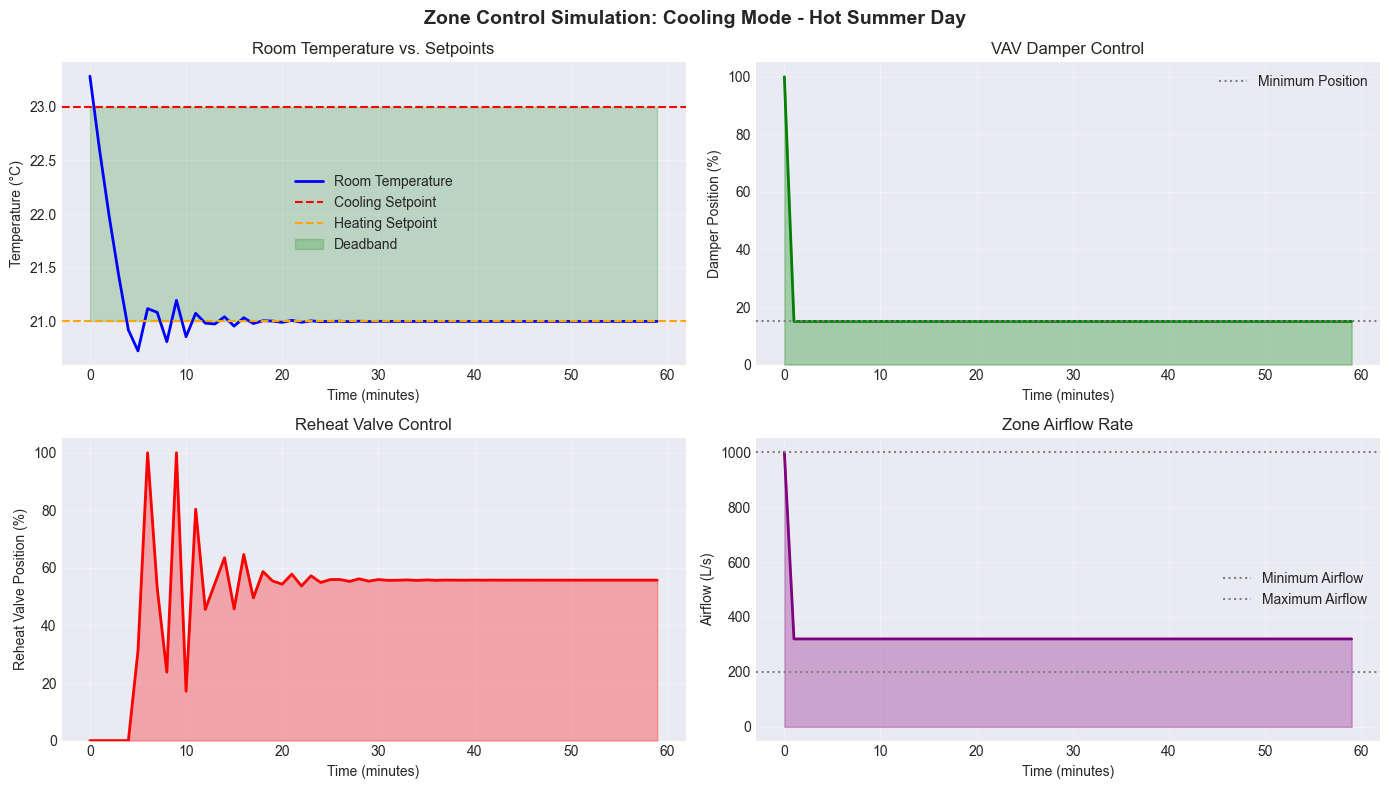


Scenario Summary: Cooling Mode - Hot Summer Day
  Initial Temperature: 26.0°C
  Final Temperature: 21.0°C
  Temperature Change: -5.0°C
  Average Damper Position: 16.4%
  Average Reheat Usage: 51.2%
  Average Airflow: 331.3 L/s


In [12]:
# Scenario 1: Cooling Mode - Hot room needs cooling
simulate_zone_scenario(
    scenario_name="Cooling Mode - Hot Summer Day",
    initial_temp=26.0,  # Room is too hot
    supply_temp=13.0,   # Cold supply air
    duration_minutes=60
)

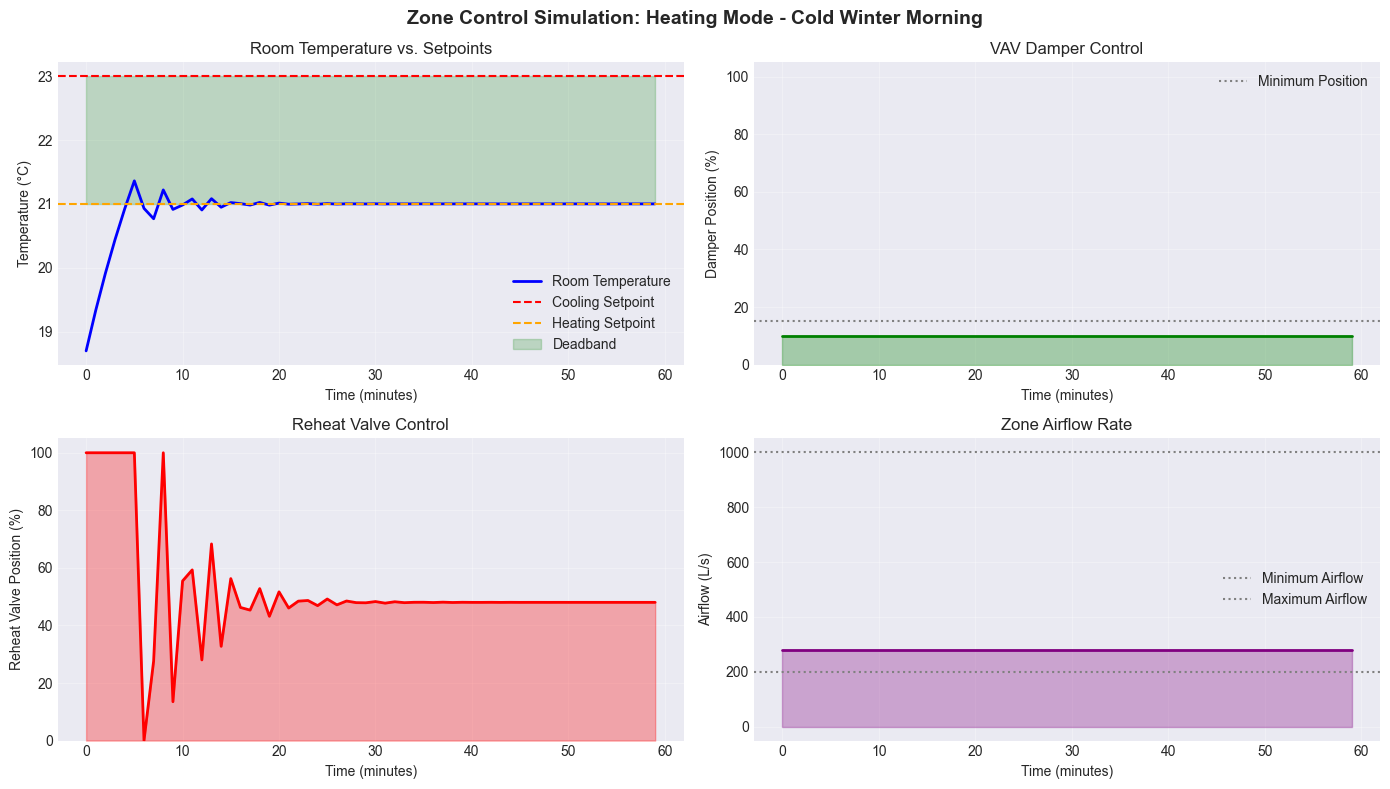


Scenario Summary: Heating Mode - Cold Winter Morning
  Initial Temperature: 18.0°C
  Final Temperature: 21.0°C
  Temperature Change: +3.0°C
  Average Damper Position: 10.0%
  Average Reheat Usage: 52.5%
  Average Airflow: 280.0 L/s


In [10]:
# Scenario 2: Heating Mode - Cold room needs reheat
simulate_zone_scenario(
    scenario_name="Heating Mode - Cold Winter Morning",
    initial_temp=18.0,  # Room is too cold
    supply_temp=13.0,   # Cold supply air (from AHU)
    duration_minutes=60
)

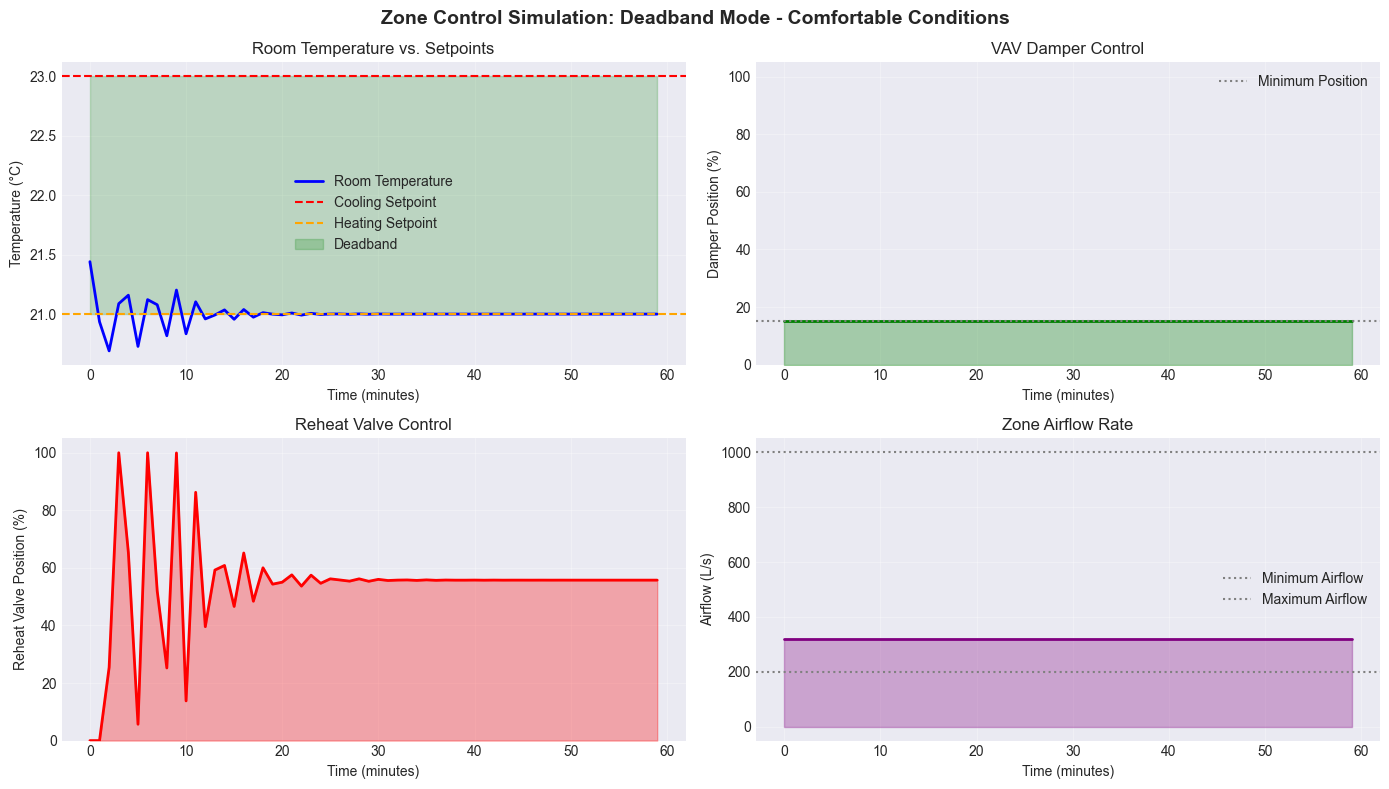


Scenario Summary: Deadband Mode - Comfortable Conditions
  Initial Temperature: 22.0°C
  Final Temperature: 21.0°C
  Temperature Change: -1.0°C
  Average Damper Position: 15.0%
  Average Reheat Usage: 54.0%
  Average Airflow: 320.0 L/s


In [6]:
# Scenario 3: Deadband Mode - Comfortable room
simulate_zone_scenario(
    scenario_name="Deadband Mode - Comfortable Conditions",
    initial_temp=22.0,  # Room is comfortable
    supply_temp=13.0,
    duration_minutes=60
)

### 🎯 Challenge Exercise 1: Tune the Controller

Try modifying the PI gains and observe the effects:

**Questions to explore:**
1. What happens if you increase `kp_damper` from 0.6 to 1.0?
2. What happens if you decrease `ki_reheat` from 0.06 to 0.02?
3. Can you make the system respond faster without overshooting?

**Tip:** Create a custom configuration and run the simulation:

In [7]:
# Your tuning experiment here
from zone_models import create_custom_zone_config

# Example: More aggressive cooling control
custom_config = create_custom_zone_config(
    zone_id="tuning_test",
    zone_type=ZoneType.SOUTH,
    cooling_setpoint=23.0,
    heating_setpoint=21.0,
    min_airflow=0.2,
    max_airflow=1.0,
    kp_damper=1.0,  # Try different values!
    ki_damper=0.15,
    kp_reheat=0.35,
    ki_reheat=0.06
)

# Replace south_config with custom_config in the simulation function
# and re-run the scenarios

---

## Section 3: AHU Control - Central Air Handling

Now let's look at the central Air Handling Unit (AHU) that supplies conditioned air to all zones.

### AHU Control Sequences

The AHU implements several coordinated control sequences:

#### 1. Mode Selection
Determines operating state based on schedule and conditions:
- **Occupied Mode**: Normal operation, full ventilation
- **Unoccupied Mode**: Reduced ventilation, setback temperatures
- **Morning Warmup**: Pre-heat before occupancy
- **Night Setback**: Energy-saving mode overnight

#### 2. Supply Fan Control
Maintains duct static pressure using VFD:
- PI control loop
- Pressure setpoint from trim & respond logic
- Minimum speed enforcement
- Fan proving for safety

#### 3. Economizer Control
Maximizes free cooling when outdoor conditions permit:
- Modulates OA/RA dampers
- Maintains mixed air temperature
- Enthalpy-based logic
- Minimum OA enforcement

#### 4. Duct Pressure Reset (Trim & Respond)
Optimizes pressure setpoint based on zone demand:
- **Trim**: Gradually reduce pressure to save energy
- **Respond**: Quickly increase pressure when zones need more air
- Prevents over-pressurization
- Can save 30-50% fan energy

### Exploring AHU Control Blocks

Let's examine the CDL block structure of each controller:

In [13]:
# Create AHU controller instances
mode_selector = ModeSelector()
supply_fan = SupplyFanController()
economizer = EconomizerController()
pressure_reset = DuctPressureReset()

print("AHU Control System Components:\n")

# Mode Selector
print("1. Mode Selector:")
print(f"   Block Type: {mode_selector.block_type}")
print(f"   Inputs: {len(mode_selector.inputs)} signals")
print(f"   Outputs: {len(mode_selector.outputs)} mode indicators")
print(f"   Parameters: {len(mode_selector.parameters)} tuning values")

# Supply Fan Controller
print("\n2. Supply Fan Controller:")
print(f"   Block Type: {supply_fan.block_type}")
print(f"   Inputs: {len(supply_fan.inputs)} signals")
print(f"   Outputs: {len(supply_fan.outputs)} commands")
print(f"   Key Parameter: Kp = {[p for p in supply_fan.parameters if p.name == 'kp'][0].value}")

# Economizer
print("\n3. Economizer Controller:")
print(f"   Block Type: {economizer.block_type}")
print(f"   Inputs: {len(economizer.inputs)} signals")
print(f"   Outputs: {len(economizer.outputs)} damper commands")
min_oa_param = [p for p in economizer.parameters if p.name == 'VOutMinFra'][0]
print(f"   Minimum OA Fraction: {min_oa_param.value*100:.0f}%")

# Pressure Reset
print("\n4. Duct Pressure Reset:")
print(f"   Block Type: {pressure_reset.block_type}")
print(f"   Inputs: {len(pressure_reset.inputs)} signals")
print(f"   Outputs: {len(pressure_reset.outputs)} setpoint")
trim_param = [p for p in pressure_reset.parameters if p.name == 'trimAmount'][0]
print(f"   Trim Amount: {trim_param.value} Pa per cycle")

AHU Control System Components:

1. Mode Selector:
   Block Type: ModeSelector
   Inputs: 5 signals
   Outputs: 4 mode indicators
   Parameters: 3 tuning values

2. Supply Fan Controller:
   Block Type: SupplyFanController
   Inputs: 4 signals
   Outputs: 3 commands
   Key Parameter: Kp = 0.5

3. Economizer Controller:
   Block Type: EconomizerController
   Inputs: 9 signals
   Outputs: 4 damper commands
   Minimum OA Fraction: 15%

4. Duct Pressure Reset:
   Block Type: DuctPressureReset
   Inputs: 2 signals
   Outputs: 1 setpoint
   Trim Amount: 25.0 Pa per cycle


### Economizer Free Cooling Demonstration

Let's visualize when the economizer can provide free cooling:

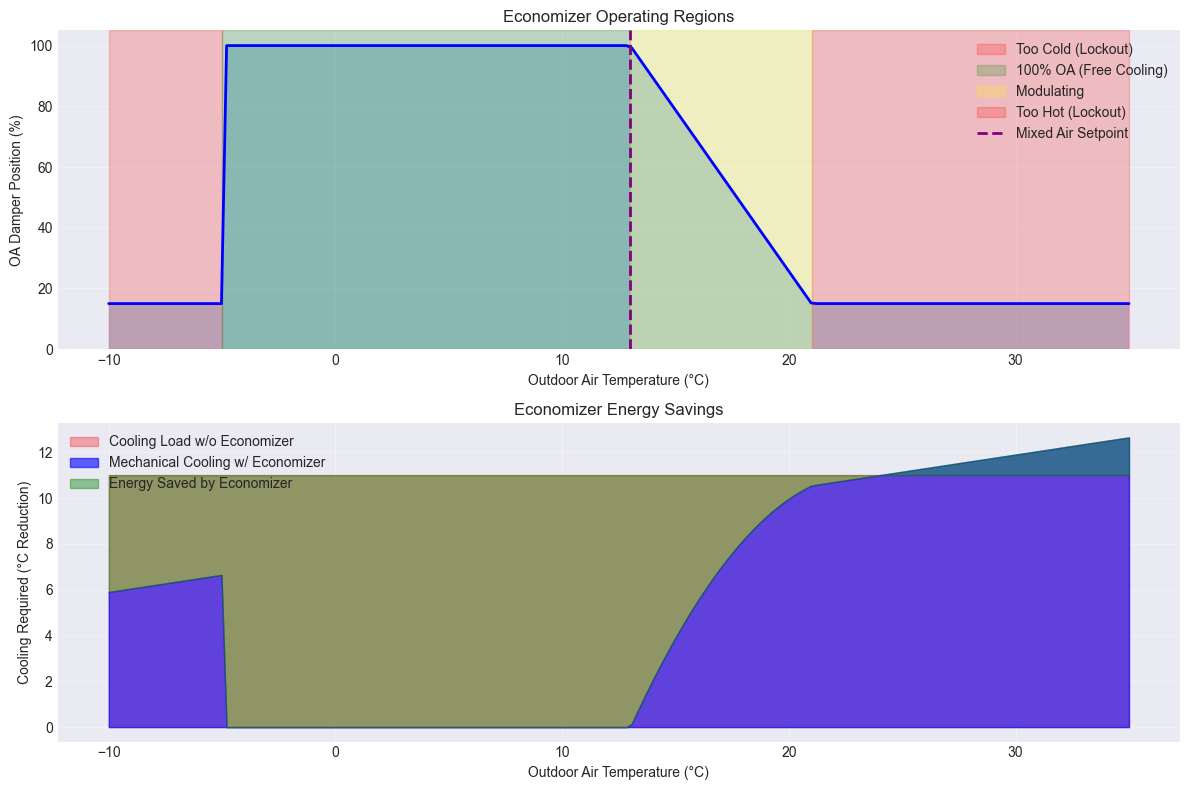


Economizer Analysis:
  Operating Range: -5.0°C to 21.0°C
  Estimated Annual Economizer Hours: 5037 hours/year
  Percentage of Year: 57.5%

  💡 Free cooling potential can reduce mechanical cooling by 30-60%!


In [14]:
def plot_economizer_operation():
    """
    Visualize economizer operating regions based on outdoor temperature.
    """
    # Temperature range
    outdoor_temps = np.linspace(-10, 35, 200)
    
    # Get economizer parameters
    t_low = -5.0  # TOutLowLim from economizer parameters
    t_high = 21.0  # TOutHighLim
    
    # Determine OA damper position based on outdoor temp
    oa_damper = np.zeros_like(outdoor_temps)
    for i, t_out in enumerate(outdoor_temps):
        if t_out < t_low or t_out > t_high:
            oa_damper[i] = 15  # Minimum OA
        elif t_out < 13:  # Below mixed air setpoint
            oa_damper[i] = 100  # 100% OA for free cooling
        else:
            # Modulating range
            oa_damper[i] = 15 + (100 - 15) * (t_high - t_out) / (t_high - 13)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Economizer operating regions
    ax1.plot(outdoor_temps, oa_damper, 'b-', linewidth=2)
    ax1.fill_between(outdoor_temps, 0, oa_damper, alpha=0.3)
    
    # Highlight regions
    ax1.axvspan(-10, t_low, alpha=0.2, color='red', label='Too Cold (Lockout)')
    ax1.axvspan(t_low, 13, alpha=0.2, color='green', label='100% OA (Free Cooling)')
    ax1.axvspan(13, t_high, alpha=0.2, color='yellow', label='Modulating')
    ax1.axvspan(t_high, 35, alpha=0.2, color='red', label='Too Hot (Lockout)')
    
    ax1.axvline(13, color='purple', linestyle='--', linewidth=2, label='Mixed Air Setpoint')
    
    ax1.set_xlabel('Outdoor Air Temperature (°C)')
    ax1.set_ylabel('OA Damper Position (%)')
    ax1.set_title('Economizer Operating Regions')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 105])
    
    # Plot 2: Energy savings potential
    # Assume cooling load proportional to (T_return - T_supply)
    t_return = 24  # Typical return air temperature
    t_supply_target = 13
    
    cooling_load = np.maximum(0, t_return - t_supply_target)  # Baseline cooling needed
    
    # With economizer, outdoor air helps
    mechanical_cooling = []
    for t_out, oa_pos in zip(outdoor_temps, oa_damper):
        oa_fraction = oa_pos / 100
        t_mixed = oa_fraction * t_out + (1 - oa_fraction) * t_return
        cooling_needed = max(0, t_mixed - t_supply_target)
        mechanical_cooling.append(cooling_needed)
    
    ax2.fill_between(outdoor_temps, 0, cooling_load, alpha=0.3, color='red', 
                     label='Cooling Load w/o Economizer')
    ax2.fill_between(outdoor_temps, 0, mechanical_cooling, alpha=0.6, color='blue',
                     label='Mechanical Cooling w/ Economizer')
    ax2.fill_between(outdoor_temps, mechanical_cooling, cooling_load, 
                     alpha=0.4, color='green', label='Energy Saved by Economizer')
    
    ax2.set_xlabel('Outdoor Air Temperature (°C)')
    ax2.set_ylabel('Cooling Required (°C Reduction)')
    ax2.set_title('Economizer Energy Savings')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print savings
    hours_per_year = 8760
    economizer_hours = np.sum((outdoor_temps >= t_low) & (outdoor_temps <= t_high)) / len(outdoor_temps) * hours_per_year
    
    print(f"\nEconomizer Analysis:")
    print(f"  Operating Range: {t_low}°C to {t_high}°C")
    print(f"  Estimated Annual Economizer Hours: {economizer_hours:.0f} hours/year")
    print(f"  Percentage of Year: {economizer_hours/hours_per_year*100:.1f}%")
    print(f"\n  💡 Free cooling potential can reduce mechanical cooling by 30-60%!")

plot_economizer_operation()

---

## Section 4: Full System Integration - 5-Zone Building

Now let's integrate everything into a complete building simulation with:
- 5 VAV zones (Corridor, North, South, East, West)
- Central AHU with economizer
- Coordinated control sequences
- 24-hour simulation with realistic loads

### Building Configuration

Let's set up our 5-zone building:

In [15]:
# Create all 5 zone configurations
zones = {
    'corridor': get_zone_config(ZoneType.CORRIDOR),
    'north': get_zone_config(ZoneType.NORTH),
    'south': get_zone_config(ZoneType.SOUTH),
    'east': get_zone_config(ZoneType.EAST),
    'west': get_zone_config(ZoneType.WEST)
}

print("Building Configuration: 5-Zone VAV System\n")
print("Zone Configurations:")
print("="*80)
print(f"{'Zone':<12} {'Type':<10} {'Cool SP':<10} {'Heat SP':<10} {'Min Flow':<12} {'Max Flow':<12}")
print("="*80)

total_min_flow = 0
total_max_flow = 0

for zone_name, config in zones.items():
    print(f"{zone_name:<12} {config.zone_type.value:<10} "
          f"{config.cooling_setpoint:<10.1f} {config.heating_setpoint:<10.1f} "
          f"{config.min_airflow*1000:<12.0f} {config.max_airflow*1000:<12.0f}")
    total_min_flow += config.min_airflow
    total_max_flow += config.max_airflow

print("="*80)
print(f"{'TOTAL':<12} {'':<10} {'':<10} {'':<10} "
      f"{total_min_flow*1000:<12.0f} {total_max_flow*1000:<12.0f}")
print("\nNote: Airflow values in L/s\n")

Building Configuration: 5-Zone VAV System

Zone Configurations:
Zone         Type       Cool SP    Heat SP    Min Flow     Max Flow    
corridor     corridor   24.0       21.0       150          600         
north        north      24.0       21.0       200          900         
south        south      23.0       21.0       200          1000        
east         east       23.5       21.0       200          950         
west         west       23.5       21.0       200          950         
TOTAL                                         950          4400        

Note: Airflow values in L/s



### Loading CDL Controller Definitions

Each zone has a CDL-JSON controller definition. Let's load and examine one:

In [16]:
# Load a zone controller from JSON
south_json_path = Path.cwd() / "south_controller.json"

with open(south_json_path, 'r') as f:
    south_controller_json = json.load(f)

print("South Zone Controller (CDL-JSON Format):\n")
print(f"Name: {south_controller_json['name']}")
print(f"Type: {south_controller_json['block_type']}")
print(f"Category: {south_controller_json['category']}")
print(f"\nDescription:\n{south_controller_json['description']}")

print(f"\nInputs ({len(south_controller_json['inputs'])}):")  
for inp in south_controller_json['inputs']:
    print(f"  - {inp['name']}: {inp['description']}")

print(f"\nOutputs ({len(south_controller_json['outputs'])}):")  
for out in south_controller_json['outputs']:
    print(f"  - {out['name']}: {out['description']}")

print(f"\nParameters ({len(south_controller_json['parameters'])}):")  
for param in south_controller_json['parameters'][:3]:  # Show first 3
    print(f"  - {param['name']}: {param['value']} {param['unit']}")
print("  ...")

South Zone Controller (CDL-JSON Format):

Name: VAVController_zone_south
Type: VAVBoxController
Category: composite

Description:
VAV box controller with reheat for zone-level control

Inputs (3):
  - room_temp: Room temperature measurement
  - supply_air_temp: Supply air temperature
  - supply_pressure: Supply air pressure (normalized)

Outputs (5):
  - damper_position: VAV damper position command
  - reheat_valve_position: Reheat valve position command
  - airflow: Zone airflow rate
  - cooling_demand: Cooling demand signal
  - heating_demand: Heating demand signal

Parameters (9):
  - cooling_setpoint: 23.0 degC
  - heating_setpoint: 21.0 degC
  - min_airflow: 0.2 m3/s
  ...


### Simplified Building Simulation

Let's create a simplified simulation to demonstrate system coordination:

In [17]:
class SimplifiedBuildingSimulation:
    """Simplified 5-zone building simulation for demonstration."""
    
    def __init__(self):
        # Create zone controllers
        self.controllers = {
            'corridor': VAVBoxController(zones['corridor']),
            'north': VAVBoxController(zones['north']),
            'south': VAVBoxController(zones['south']),
            'east': VAVBoxController(zones['east']),
            'west': VAVBoxController(zones['west'])
        }
        
        # Initial zone states
        self.states = {
            'corridor': ZoneState(room_temp=20.0, supply_air_temp=13.0),
            'north': ZoneState(room_temp=19.0, supply_air_temp=13.0),
            'south': ZoneState(room_temp=25.0, supply_air_temp=13.0),  # Hot from sun
            'east': ZoneState(room_temp=24.0, supply_air_temp=13.0),
            'west': ZoneState(room_temp=22.0, supply_air_temp=13.0)
        }
        
        # AHU state
        self.supply_temp = 13.0
        self.outdoor_temp = 15.0
        self.duct_pressure = 250.0
        
    def step(self, hour_of_day: float):
        """Execute one simulation step."""
        # Update outdoor temperature (sinusoidal daily cycle)
        self.outdoor_temp = 15.0 + 8.0 * np.sin((hour_of_day - 6) * np.pi / 12)
        
        # Determine occupancy
        occupied = 7 <= hour_of_day < 18
        
        # Update each zone
        zone_data = {}
        for zone_name, controller in self.controllers.items():
            state = self.states[zone_name]
            state.supply_air_temp = self.supply_temp
            
            # Compute control
            state = controller.update_state(state, dt=300.0)  # 5 min
            
            # Simple thermal model
            # (In reality, would use detailed heat balance)
            q_supply = state.airflow * 1.2 * 1005 * (self.supply_temp - state.room_temp)
            q_reheat = state.reheat_valve_position * 5000
            q_envelope = -2.0 * 100 * (state.room_temp - self.outdoor_temp)
            q_internal = 1500 if occupied else 300
            
            # Solar gains (simplified)
            if zone_name == 'south' and 10 <= hour_of_day <= 16:
                q_internal += 2000  # Additional solar gain
            elif zone_name == 'east' and 6 <= hour_of_day <= 12:
                q_internal += 1500
            elif zone_name == 'west' and 12 <= hour_of_day <= 18:
                q_internal += 1500
            
            thermal_mass = 300 * 1.2 * 1005
            dT = ((q_supply + q_reheat + q_envelope + q_internal) * 300) / thermal_mass
            state.room_temp += dT
            
            zone_data[zone_name] = {
                'temp': state.room_temp,
                'damper': state.damper_position * 100,
                'reheat': state.reheat_valve_position * 100,
                'airflow': state.airflow * 1000
            }
        
        return zone_data

# Run a quick simulation
sim = SimplifiedBuildingSimulation()
print("Simplified Building Simulation Created")
print(f"  5 zones with VAV controllers")
print(f"  Supply air temperature: {sim.supply_temp}°C")
print(f"  Initial outdoor temperature: {sim.outdoor_temp}°C")

Simplified Building Simulation Created
  5 zones with VAV controllers
  Supply air temperature: 13.0°C
  Initial outdoor temperature: 15.0°C


### Run 24-Hour Building Simulation

Running 24-hour simulation...
Simulation complete!


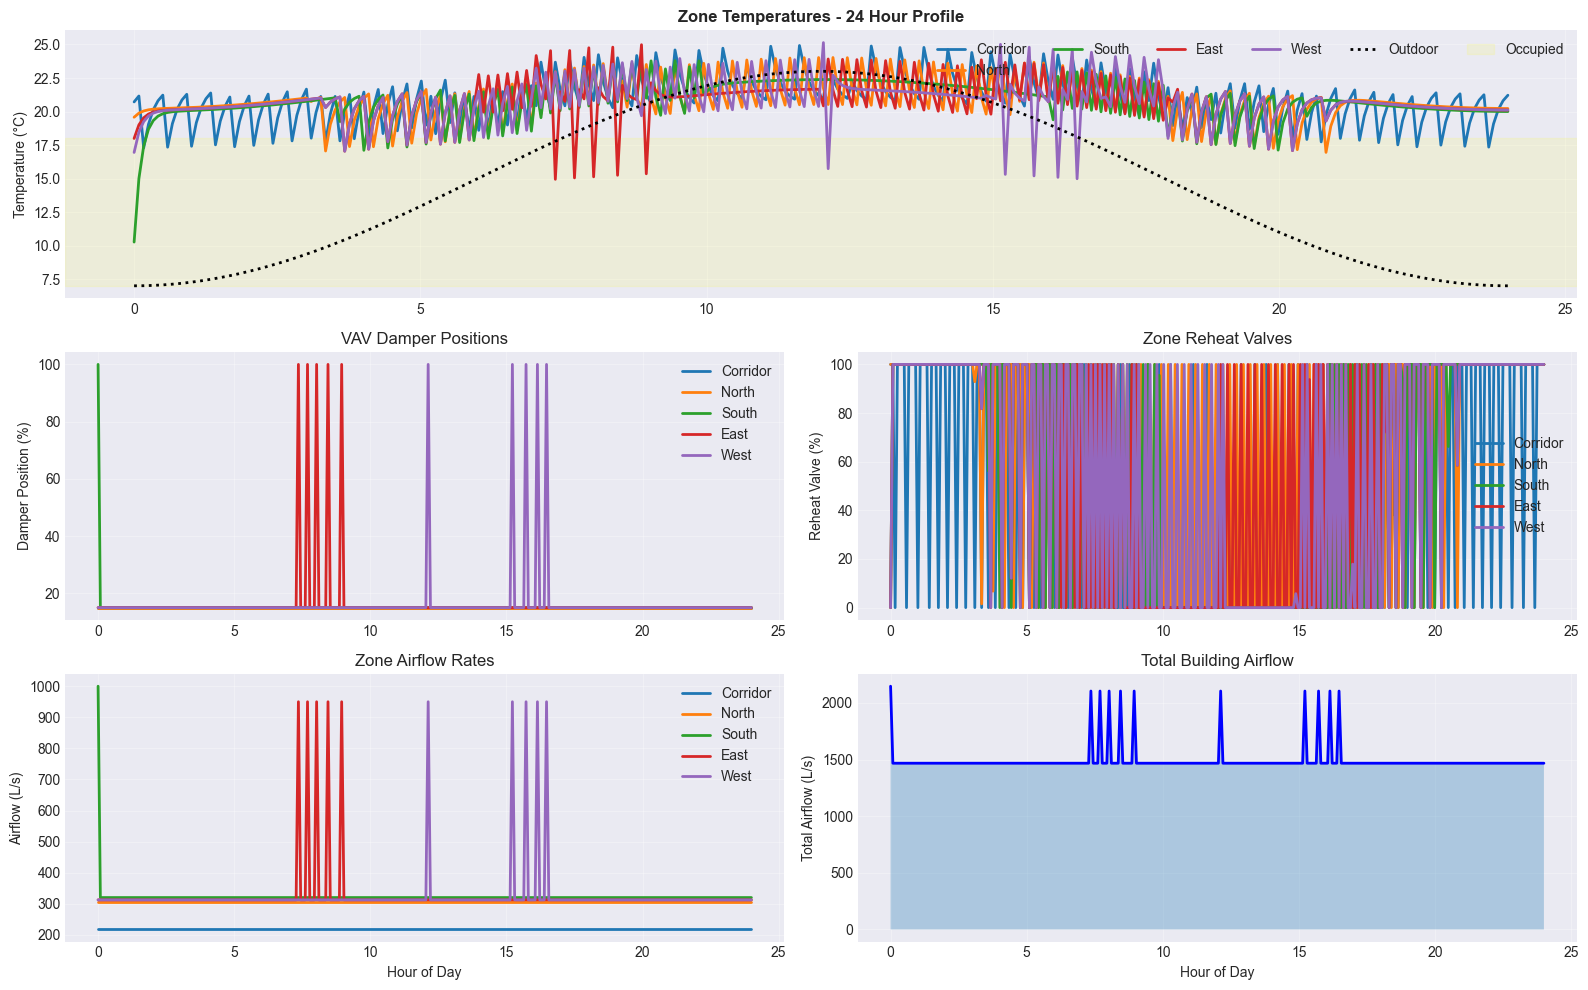


24-Hour Performance Summary:

CORRIDOR:
  Avg Temperature: 21.0°C
  Temp Range: 17.3 - 24.9°C
  Avg Reheat Usage: 48.7%
  Avg Airflow: 217 L/s

NORTH:
  Avg Temperature: 20.9°C
  Temp Range: 17.0 - 24.0°C
  Avg Reheat Usage: 64.9%
  Avg Airflow: 305 L/s

SOUTH:
  Avg Temperature: 20.8°C
  Temp Range: 10.3 - 23.8°C
  Avg Reheat Usage: 57.3%
  Avg Airflow: 322 L/s

EAST:
  Avg Temperature: 20.8°C
  Temp Range: 14.9 - 25.0°C
  Avg Reheat Usage: 60.5%
  Avg Airflow: 324 L/s

WEST:
  Avg Temperature: 20.8°C
  Temp Range: 15.0 - 25.1°C
  Avg Reheat Usage: 60.3%
  Avg Airflow: 324 L/s

BUILDING TOTAL:
  Average Total Airflow: 1492 L/s
  Peak Total Airflow: 2148 L/s


In [18]:
# Run simulation for 24 hours
hours = np.linspace(0, 24, 24*12)  # 5-minute intervals
history = {zone: {'temp': [], 'damper': [], 'reheat': [], 'airflow': []} 
           for zone in ['corridor', 'north', 'south', 'east', 'west']}
outdoor_temps = []

print("Running 24-hour simulation...")
for hour in hours:
    data = sim.step(hour)
    outdoor_temps.append(sim.outdoor_temp)
    
    for zone_name, zone_data in data.items():
        for key, value in zone_data.items():
            history[zone_name][key].append(value)

print("Simulation complete!")

# Plot comprehensive results
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, figure=fig)

# Zone Temperatures
ax1 = fig.add_subplot(gs[0, :])
for zone_name in ['corridor', 'north', 'south', 'east', 'west']:
    ax1.plot(hours, history[zone_name]['temp'], linewidth=2, label=zone_name.capitalize())
ax1.plot(hours, outdoor_temps, 'k:', linewidth=2, label='Outdoor')
ax1.axhspan(7, 18, alpha=0.1, color='yellow', label='Occupied')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Zone Temperatures - 24 Hour Profile', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', ncol=6)
ax1.grid(True, alpha=0.3)

# Damper Positions
ax2 = fig.add_subplot(gs[1, 0])
for zone_name in ['corridor', 'north', 'south', 'east', 'west']:
    ax2.plot(hours, history[zone_name]['damper'], linewidth=2, label=zone_name.capitalize())
ax2.set_ylabel('Damper Position (%)')
ax2.set_title('VAV Damper Positions')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Reheat Valves
ax3 = fig.add_subplot(gs[1, 1])
for zone_name in ['corridor', 'north', 'south', 'east', 'west']:
    ax3.plot(hours, history[zone_name]['reheat'], linewidth=2, label=zone_name.capitalize())
ax3.set_ylabel('Reheat Valve (%)')
ax3.set_title('Zone Reheat Valves')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Airflow Rates
ax4 = fig.add_subplot(gs[2, 0])
for zone_name in ['corridor', 'north', 'south', 'east', 'west']:
    ax4.plot(hours, history[zone_name]['airflow'], linewidth=2, label=zone_name.capitalize())
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Airflow (L/s)')
ax4.set_title('Zone Airflow Rates')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# Total Building Airflow
ax5 = fig.add_subplot(gs[2, 1])
total_airflow = np.sum([history[zone]['airflow'] for zone in history.keys()], axis=0)
ax5.plot(hours, total_airflow, 'b-', linewidth=2)
ax5.fill_between(hours, 0, total_airflow, alpha=0.3)
ax5.set_xlabel('Hour of Day')
ax5.set_ylabel('Total Airflow (L/s)')
ax5.set_title('Total Building Airflow')
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n24-Hour Performance Summary:")
print("="*60)
for zone_name in ['corridor', 'north', 'south', 'east', 'west']:
    temps = np.array(history[zone_name]['temp'])
    avg_reheat = np.mean(history[zone_name]['reheat'])
    avg_airflow = np.mean(history[zone_name]['airflow'])
    
    print(f"\n{zone_name.upper()}:")
    print(f"  Avg Temperature: {np.mean(temps):.1f}°C")
    print(f"  Temp Range: {np.min(temps):.1f} - {np.max(temps):.1f}°C")
    print(f"  Avg Reheat Usage: {avg_reheat:.1f}%")
    print(f"  Avg Airflow: {avg_airflow:.0f} L/s")

avg_total_airflow = np.mean(total_airflow)
print(f"\nBUILDING TOTAL:")
print(f"  Average Total Airflow: {avg_total_airflow:.0f} L/s")
print(f"  Peak Total Airflow: {np.max(total_airflow):.0f} L/s")

---

## Section 5: Advanced Topics

### Tuning PI Controllers

PI (Proportional-Integral) controllers are the workhorses of HVAC control. Understanding how to tune them is crucial.

#### PI Control Equation:

$$u(t) = K_p \cdot e(t) + K_i \cdot \int_0^t e(\tau) d\tau$$

Where:
- $u(t)$ = control output
- $e(t)$ = error (setpoint - measurement)
- $K_p$ = proportional gain
- $K_i$ = integral gain

#### Tuning Guidelines:

**Proportional Gain ($K_p$):**
- **Too Low**: Slow response, large steady-state error
- **Too High**: Fast response but overshoot and oscillation
- **Rule of Thumb**: Start with 0.5 for temperature control

**Integral Gain ($K_i$):**
- **Too Low**: Slow elimination of steady-state error
- **Too High**: Oscillation and instability  
- **Rule of Thumb**: Start with 0.05-0.1 for temperature control

**Tuning Method (Ziegler-Nichols Modified):**
1. Set $K_i = 0$
2. Gradually increase $K_p$ until oscillation occurs
3. Set $K_p$ to 50-60% of oscillation value
4. Slowly increase $K_i$ until steady-state error is eliminated
5. Fine-tune for desired response

### Trim & Respond Logic for Duct Pressure

This advanced energy-saving strategy optimizes duct static pressure:

#### Algorithm:

```python
# RESPOND (Fast - every 30 seconds)
if any_damper_position > 90%:
    pressure_setpoint += 25 Pa  # Increase immediately

# TRIM (Slow - every 5 minutes)  
if all_damper_positions < 90% for 5 minutes:
    pressure_setpoint -= 25 Pa  # Decrease gradually

# Clamp to limits
pressure_setpoint = clamp(pressure_setpoint, 75 Pa, 400 Pa)
```

#### Why This Saves Energy:

Fan power follows the "cube law":
$$P \propto Q^3$$

Reducing pressure by 50% saves ~75% fan energy!

**Real-World Results:**
- 30-50% fan energy savings typical
- Payback period: 6-18 months
- No impact on zone comfort if properly tuned

### Economizer Optimization

The economizer can provide significant energy savings through "free cooling".

#### Integrated Economizer Control:

**Decision Logic:**
1. **Temperature Check**: Is outdoor temp in acceptable range?
2. **Enthalpy Check**: Is outdoor enthalpy less than return air?
3. **Cooling Demand**: Does building need cooling?
4. **Safety**: Check freeze stats, high wind, etc.

**Operating Modes:**

| Outdoor Condition | OA Damper | Mode |
|------------------|-----------|------|
| < -5°C | Minimum | Lockout (too cold) |
| -5°C to 13°C | 100% | Free cooling |
| 13°C to 21°C | Modulating | Economizer mode |
| > 21°C | Minimum | Lockout (too hot) |

**Energy Impact:**
- Can provide 100% cooling during swing seasons
- Typical savings: 20-40% annual cooling energy
- Payback: 1-3 years

---

## Section 6: Practical Exercises

### Exercise 1: Optimize a Problematic Zone

**Scenario:** The north zone tends to overshoot its setpoint and oscillate.

**Your Task:**
1. Identify which PI gains need adjustment
2. Test different gain combinations
3. Minimize overshoot while maintaining fast response

**Starter Code:**

In [ ]:
# Exercise 1: Your solution here

# Hint: Create custom config with modified gains
# Then run simulation and observe results

# Example structure:
# exercise1_config = create_custom_zone_config(
#     zone_id="exercise1",
#     zone_type=ZoneType.NORTH,
#     cooling_setpoint=24.0,
#     heating_setpoint=21.0,
#     min_airflow=0.2,
#     max_airflow=0.9,
#     kp_damper=0.55,  # Try modifying these!
#     ki_damper=0.11,
#     kp_reheat=0.35,
#     ki_reheat=0.06
# )

# Then create controller and test with simulation

### Exercise 2: Minimize Reheat Energy

**Scenario:** Reheat energy is expensive. Can you reduce reheat usage without sacrificing comfort?

**Your Task:**
1. Identify when and why reheat is being used
2. Try adjusting deadband, setpoints, or minimum airflow
3. Calculate energy savings

**Questions to Explore:**
- What happens if you increase the deadband from 1°C to 1.5°C?
- Can you reduce minimum airflow without comfort issues?
- Would a higher supply air temperature help?

In [ ]:
# Exercise 2: Your solution here

# Hint: Compare total reheat usage before and after changes
# Calculate percentage reduction in reheat energy

### Exercise 3: Design a Custom Control Sequence

**Challenge:** Design a night-time purge sequence that:
1. Uses 100% outdoor air when outdoor temp < indoor temp
2. Runs fans at high speed to flush heat from building
3. Executes 2-4 AM for next-day cooling load reduction

**Bonus:** Estimate energy savings from pre-cooling the building thermal mass

In [ ]:
# Exercise 3: Your solution here

# Hint: Modify the building simulation to include 
# night purge logic between 2-4 AM

---

## Section 7: Troubleshooting Guide

### Common VAV System Issues

#### Problem: Zone Won't Cool

**Symptoms:**
- Room temperature above setpoint
- Damper at 100% open
- No cooling happening

**Possible Causes:**
1. ✓ Check duct static pressure - may be too low
2. ✓ Check AHU supply temperature - may be too high
3. ✓ Verify damper actuator is working
4. ✓ Check for duct leaks or obstructions
5. ✓ Verify zone airflow setpoints are achievable

#### Problem: Simultaneous Heating and Cooling

**Symptoms:**
- Reheat valve open while in cooling mode
- High energy bills
- Fighting between AHU and zone control

**Possible Causes:**
1. ✓ Supply air too cold - raise AHU supply temp
2. ✓ Minimum airflow too high - reduce if possible
3. ✓ Deadband too narrow - increase to 1.5-2°C
4. ✓ Check reheat valve for leakage when closed

#### Problem: System Oscillation

**Symptoms:**
- Temperature cycling up and down
- Control outputs hunting
- Occupant complaints

**Possible Causes:**
1. ✓ PI gains too high - reduce Kp and Ki
2. ✓ Sensor location poor - move to representative location
3. ✓ Time constants mismatched - slow down faster loop
4. ✓ Actuator binding or sticking - service mechanically

---

## Section 8: Next Steps and Resources

### What You've Learned

Congratulations! You now understand:

✓ VAV system fundamentals and energy benefits  
✓ ASHRAE Guideline 36 control sequences  
✓ Zone-level VAV box control with reheat  
✓ Central AHU control (fans, economizer, mode selection)  
✓ Multi-zone system coordination  
✓ PI controller tuning  
✓ Energy optimization strategies  
✓ Common troubleshooting approaches  

### Further Learning

**Standards & Guidelines:**
- ASHRAE Guideline 36-2021: High Performance Sequences of Operation
- ASHRAE Standard 90.1: Energy Standard for Buildings
- ASHRAE Standard 62.1: Ventilation for Acceptable Indoor Air Quality

**Books:**
- "HVAC Control Systems" by Robert McDowall
- "Modern Control Technology" by Christopher Kilian
- "Energy Management Handbook" by Wayne Turner

**Online Resources:**
- ASHRAE Learning Institute courses
- Building Automation Monthly webinars
- ControlTrends podcast and blog

### Python CDL Documentation

For more information on the Python CDL library:
- GitHub: [python-cdl repository](https://github.com/your-repo)
- Examples: `/examples/` directory
- API Documentation: `/docs/` directory

### Practice Projects

Try these projects to build your skills:

1. **Add Demand-Controlled Ventilation (DCV)**
   - Use CO2 sensors to modulate outdoor air
   - Calculate energy savings vs. fixed minimum OA

2. **Implement Supply Air Temperature Reset**
   - Raise SAT when all zones are satisfied
   - Measure impact on fan energy and reheat

3. **Create a Fault Detection Diagnostic (FDD) System**
   - Detect simultaneous heating/cooling
   - Identify stuck dampers or sensors
   - Alert operators to inefficiencies

4. **Build a Digital Twin**
   - Use actual building data
   - Calibrate thermal models
   - Test control strategies before deployment

---

## Conclusion

Thank you for completing this VAV Reheat System tutorial!

You've learned the fundamental concepts and practical implementation of modern HVAC control systems. The principles you've learned here apply to:

- Commercial office buildings
- Educational facilities  
- Healthcare facilities
- Laboratories
- Any building with variable occupancy and loads

Remember:
- **Start simple** - Get basic control working before optimization
- **Test thoroughly** - Simulate before deploying to real systems
- **Monitor continuously** - Use data to identify issues early
- **Optimize systematically** - Change one parameter at a time

**Questions or feedback?** Open an issue on the python-cdl GitHub repository.

---

*This tutorial was created for Python CDL - Control Description Language implementation in Python*

*Last updated: October 2025*